In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics

In [28]:
# read the cleaned real estate and matched listings.

df_train = pd.read_csv('./Cleaned_Data/train_v00_tuned.csv')
df_train_match = pd.read_csv('./Cleaned_Data/train_match_v00_tuned.csv')

/var/folders/_w/k40rbx_x0yd88dyx542lggnc0000gn/T/ipykernel_77313/2191887507.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('./Cleaned_Data/train_v01.csv')


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83051 entries, 0 to 83050
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           83049 non-null  float64
 1   sourceId     83049 non-null  float64
 2   locationId   83049 non-null  float64
 3   regionId     83049 non-null  float64
 4   provinceId   83049 non-null  float64
 5   countryId    83049 non-null  float64
 6   typeId       83049 non-null  float64
 7   price        76873 non-null  float64
 8   rooms        8486 non-null   float64
 9   bedrooms     70207 non-null  float64
 10  bathrooms    68227 non-null  float64
 11  totalArea    56709 non-null  float64
 12  livingArea   30921 non-null  float64
 13  plotArea     44257 non-null  float64
 14  terraceArea  17130 non-null  float64
 15  title        78745 non-null  object 
 16  description  80189 non-null  object 
 17  features     42330 non-null  object 
 18  latitude     15925 non-null  object 
 19  long

In [30]:
df_train_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884125 entries, 0 to 884124
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id1     884125 non-null  int64
 1   id2     884125 non-null  int64
 2   match?  884125 non-null  int64
dtypes: int64(3)
memory usage: 20.2 MB


In [31]:
# convert all categories to integer.

df_train['id'] = df_train['id'].convert_dtypes('int')
df_train['sourceId'] = df_train['sourceId'].convert_dtypes('int')
df_train['locationId'] = df_train['locationId'].convert_dtypes('int')
df_train['locationId'] = df_train['locationId'].convert_dtypes('int')
df_train['regionId'] = df_train['regionId'].convert_dtypes('int')
df_train['provinceId'] = df_train['provinceId'].convert_dtypes('int')
df_train['countryId'] = df_train['countryId'].convert_dtypes('int')
df_train['typeId'] = df_train['typeId'].convert_dtypes('int')

In [33]:
# drop the non-numeric features. latitude and longitude are mostly empty. so being dropped.

df_train.drop(columns=['sourceId','title','description','features','latitude','longitude','thumbnails'], axis=1, inplace=True)

In [41]:
# function to create the numeric features for input into models. The final set of features comprise of differentials between any two real estate listings and also the matching
# of their locations.

def create_feature_list(df_train_match, df_train):

    feature_list = []
        
    for i in range(len(df_train_match)):

        print(i)
        
        list_id1 = []
        list_id2 = []

        compared_list = []

        list_id1 = df_train[df_train['id']==df_train_match['id1'].iloc[i]].values.tolist()
        list_id2 = df_train[df_train['id']==df_train_match['id2'].iloc[i]].values.tolist()
        
        compared_list.append(1) if list_id1[0][1] == list_id2[0][1] else compared_list.append(0)
        compared_list.append(1) if list_id1[0][2] == list_id2[0][2] else compared_list.append(0)
        compared_list.append(1) if list_id1[0][3] == list_id2[0][3] else compared_list.append(0)
        compared_list.append(1) if list_id1[0][4] == list_id2[0][4] else compared_list.append(0)
        compared_list.append(1) if list_id1[0][5] == list_id2[0][5] else compared_list.append(0)
        
        compared_list.append(abs(list_id1[0][6]-list_id2[0][6])/max(list_id1[0][6],list_id2[0][6]))
        compared_list.append(abs(list_id1[0][7]-list_id2[0][7])/max(list_id1[0][7],list_id2[0][7]))
        compared_list.append(abs(list_id1[0][8]-list_id2[0][8])/max(list_id1[0][8],list_id2[0][8]))
        compared_list.append(abs(list_id1[0][9]-list_id2[0][9])/max(list_id1[0][9],list_id2[0][9]))
        compared_list.append(abs(list_id1[0][10]-list_id2[0][10])/max(list_id1[0][10],list_id2[0][10]))
        compared_list.append(abs(list_id1[0][11]-list_id2[0][11])/max(list_id1[0][11],list_id2[0][11]))
        compared_list.append(abs(list_id1[0][12]-list_id2[0][12])/max(list_id1[0][12],list_id2[0][12]))
        compared_list.append(abs(list_id1[0][13]-list_id2[0][13])/max(list_id1[0][13],list_id2[0][13]))

        feature_list.append(compared_list)
        
    return(feature_list)
    

In [ ]:
# create the final feature list for input to models.

feature_list = create_feature_list(df_train_match, df_train)

In [45]:
# convert the list of features to a dataframe with the column names as final set of numeric features.

df_features = pd.DataFrame(feature_list, columns=['location_match?','region_match?','province_match?','country_match?','type_match?',
                                                  'price_diff','rooms_diff','bedrooms_diff','bathrooms_diff','total_area_diff',
                                                  'living_area_diff','plot_area_diff','terrace_area_diff'])

In [47]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884125 entries, 0 to 884124
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   location_match?    884125 non-null  int64  
 1   region_match?      884125 non-null  int64  
 2   province_match?    884125 non-null  int64  
 3   country_match?     884125 non-null  int64  
 4   type_match?        884125 non-null  int64  
 5   price_diff         676378 non-null  float64
 6   rooms_diff         5012 non-null    float64
 7   bedrooms_diff      831271 non-null  float64
 8   bathrooms_diff     762866 non-null  float64
 9   total_area_diff    514004 non-null  float64
 10  living_area_diff   191446 non-null  float64
 11  plot_area_diff     439810 non-null  float64
 12  terrace_area_diff  58265 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 87.7 MB


In [49]:
# save the final derived set of features and data into a csv file for future reference, if needed.

df_features.to_csv('./Cleaned_Data/features_v00.csv', index=False)

In [1421]:
# save the target values into a target variable for supervised learning.

y = df_train_match['match?'].values

In [1430]:
# train, test split of data.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

In [1431]:
X_train.shape

(707300, 13)

In [1438]:
X_test.shape

(176825, 13)

In [1442]:
# use grid search to find the optimal hyperparameters for xgboost algorithm.

from sklearn.model_selection import GridSearchCV

estimator = xgb.XGBClassifier()

parameters = {
    'max_depth': [5, 10, 15],
    'n_estimators': range(50, 200, 25),
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'random_state': [42]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 5,
    cv = 5
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': [5, 10, 15],
                         'n_estimators': range(50, 200, 25),
                         'random_state': [42]})

In [1443]:
grid_search.best_params_

{'learning_rate': 0.09,
 'max_depth': 15,
 'n_estimators': 175,
 'random_state': 42}

In [1444]:
grid_search.best_score_

0.9004863565672274

In [1445]:
# run xgboost algorithm on the training data.

xgb_cl = xgb.XGBClassifier(max_depth=15, learning_rate=0.09, n_estimators=175, random_state=42)

xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.09, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=15, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=175, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

accuracy Score: 0.9032659409020217


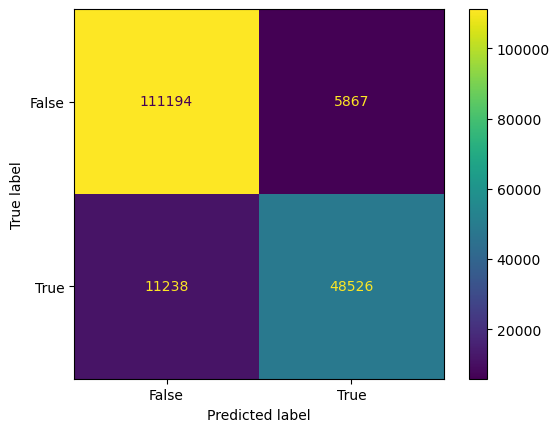

In [1446]:
# find the confusion matrix and accuracy score.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = xgb_cl.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred))

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()

In [1452]:
# run gridsearch to find optimal hyperparamters for histgradientbooster.

from sklearn.model_selection import GridSearchCV

estimator = HistGradientBoostingClassifier()

parameters = {
    'max_depth': [5, 10, 15],
    'max_iter': range(50, 200, 25),
    'max_leaf_nodes': [20, 25, 30],
    'learning_rate': np.arange(0.02, 0.2, 0.02),
    'random_state': [42]
}

gs_hgbc = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 5,
    cv = 5
)

gs_hgbc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_jobs=5,
             param_grid={'learning_rate': array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18]),
                         'max_depth': [5, 10, 15],
                         'max_iter': range(50, 200, 25),
                         'max_leaf_nodes': [20, 25, 30], 'random_state': [42]})

In [1517]:
gs_hgbc.best_params_

{'learning_rate': 0.18,
 'max_depth': 15,
 'max_iter': 175,
 'max_leaf_nodes': 30,
 'random_state': 42}

In [1518]:
# run hisgradientbooster with optimized parameters.

from sklearn.ensemble import HistGradientBoostingClassifier

hgbc_cl = HistGradientBoostingClassifier(learning_rate=0.18, max_depth=15, max_iter=175,max_leaf_nodes=30,random_state=42).fit(X_train, y_train)

hgbc_cl.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.18, max_depth=15, max_iter=175,
                               max_leaf_nodes=30, random_state=42)

accuracy Score: 0.8685027569630991


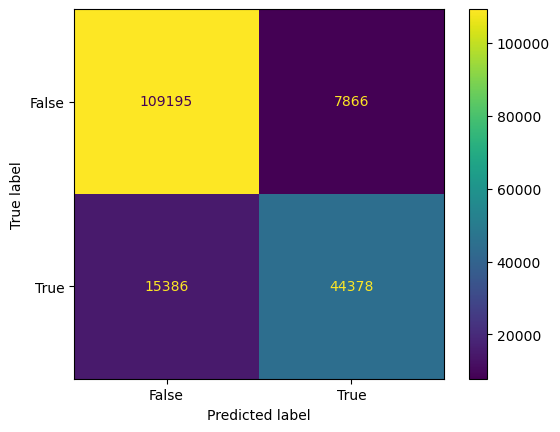

In [1519]:
# find the confusion matrix.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_hgbc2 = hgbc_cl.predict(X_test)

print("accuracy Score:", accuracy_score(y_test, y_pred_hgbc2))

confusion_matrix = confusion_matrix(y_test, y_pred_hgbc2)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

plt.show()

In [1520]:
# save the models to files for future reference and usage if needed.

import pickle

# Save to a file using Pickle
with open('model_xgb.pkl', 'wb') as file_handle: # wb=write binary
    pickle.dump(xgb_cl, file_handle)

with open('model_hgbc.pkl', 'wb') as file_handle: # wb=write binary
    pickle.dump(hgbc_cl, file_handle)
